## 1. Data & package loading

In [35]:
%matplotlib inline

import os
from pathlib import Path
import pickle

# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency

# library for sampling
from imblearn.combine import SMOTEENN

# library for ML
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
SEED = 1111


In [2]:
data_fpath = "/home/tom/PRJ/Riiid/question3/data/data.csv"

df = pd.read_csv(data_fpath)

# column rename
def text_norm(text):
    return text.lower().replace(' ',"_").replace("-","_")
df.columns  = list(map(text_norm,df.columns))

target_column = "adaptivity_level"

df.head()


,gender,age,education_level,institution_type,it_student,location,load_shedding,financial_condition,internet_type,network_type,class_duration,self_lms,device,adaptivity_level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


## 2. Explore Data Analysis

### 2-1. Data type and summary

모든 데이터가 categorical 데이터 임을 확인

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               1205 non-null   object
 1   age                  1205 non-null   object
 2   education_level      1205 non-null   object
 3   institution_type     1205 non-null   object
 4   it_student           1205 non-null   object
 5   location             1205 non-null   object
 6   load_shedding        1205 non-null   object
 7   financial_condition  1205 non-null   object
 8   internet_type        1205 non-null   object
 9   network_type         1205 non-null   object
 10  class_duration       1205 non-null   object
 11  self_lms             1205 non-null   object
 12  device               1205 non-null   object
 13  adaptivity_level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [4]:
for column_name in list(df.columns):
    print(f"* {column_name}, {df[column_name].dtype}, {list(df[column_name].unique())}")

* gender, object, ['Boy', 'Girl']
* age, object, ['21-25', '16-20', '11-15', '26-30', '6-10', '1-5']
* education_level, object, ['University', 'College', 'School']
* institution_type, object, ['Non Government', 'Government']
* it_student, object, ['No', 'Yes']
* location, object, ['Yes', 'No']
* load_shedding, object, ['Low', 'High']
* financial_condition, object, ['Mid', 'Poor', 'Rich']
* internet_type, object, ['Wifi', 'Mobile Data']
* network_type, object, ['4G', '3G', '2G']
* class_duration, object, ['3-6', '1-3', '0']
* self_lms, object, ['No', 'Yes']
* device, object, ['Tab', 'Mobile', 'Computer']
* adaptivity_level, object, ['Moderate', 'Low', 'High']


In [5]:
df.nunique().sort_values()

gender                 2
institution_type       2
it_student             2
location               2
load_shedding          2
internet_type          2
self_lms               2
education_level        3
financial_condition    3
network_type           3
class_duration         3
device                 3
adaptivity_level       3
age                    6
dtype: int64

### 2-2. Dependent(종속) Data

학습할 때 사용되는 데이터의 종속 변수가 imbalance 하다는 것을 확인.

<Axes: xlabel='adaptivity_level', ylabel='count'>

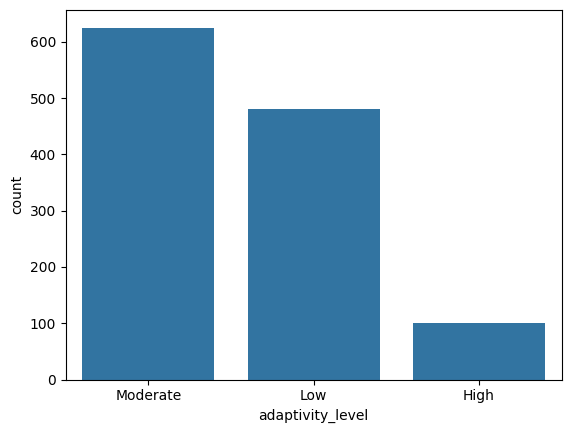

In [6]:
sns.countplot(x=target_column, data = df)

### 2-3. Independent(독립) Data

#### column 별 데이터 분포 확인

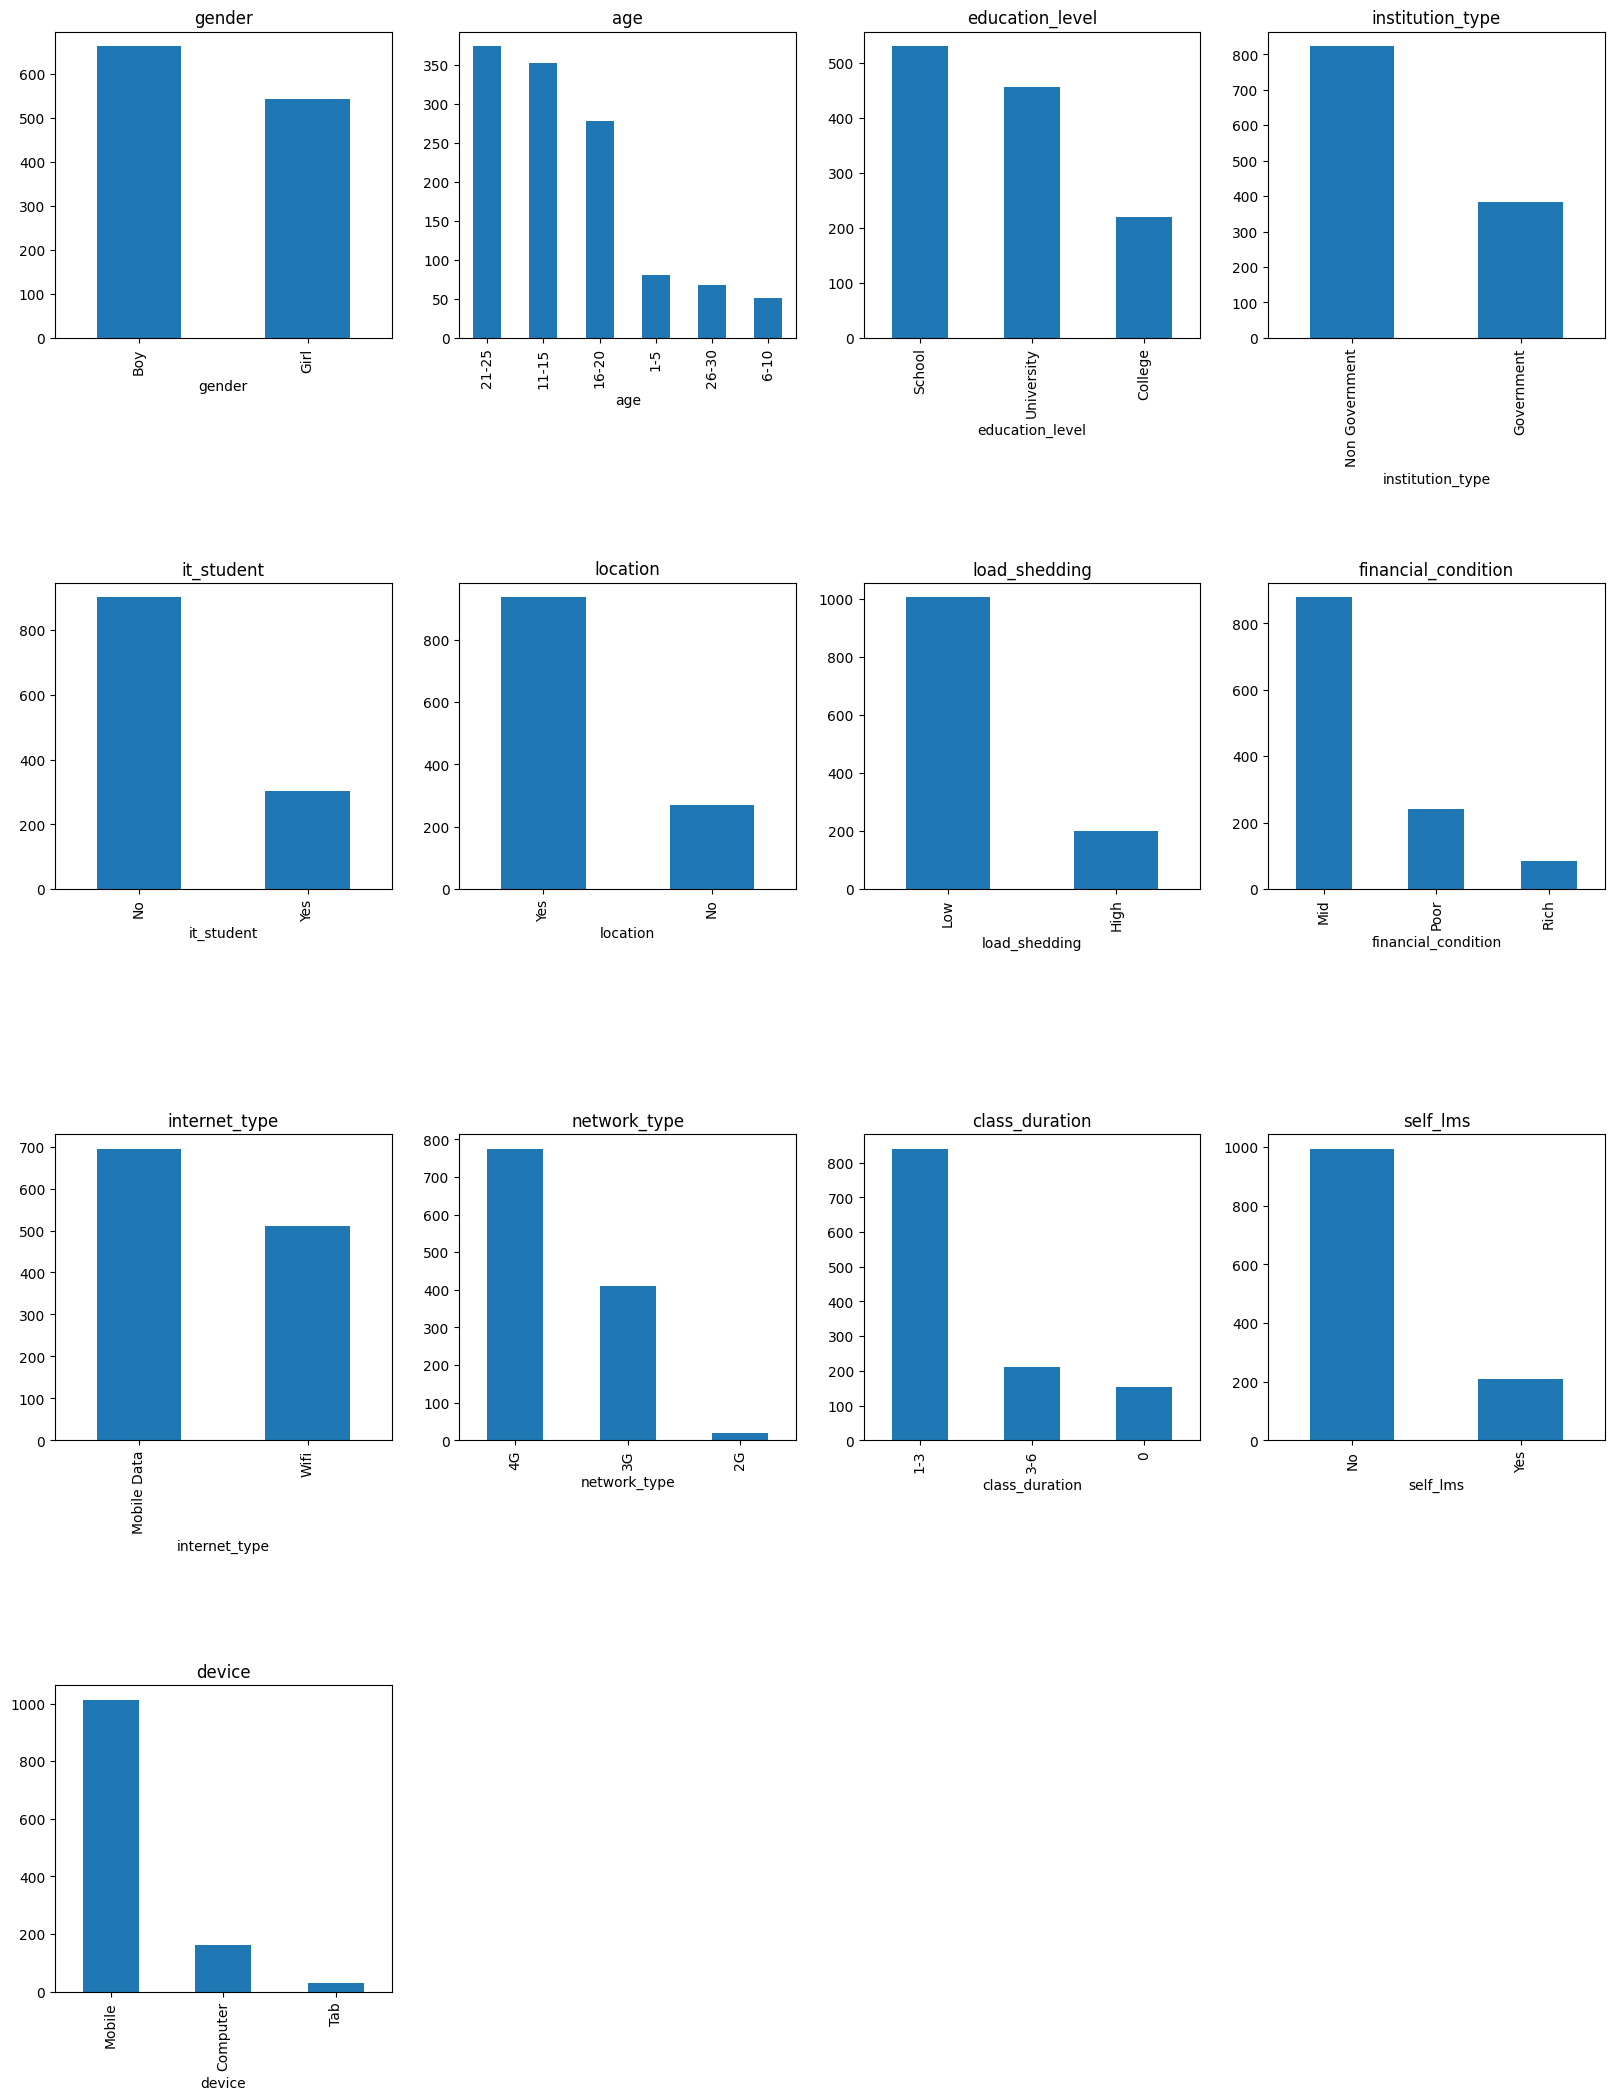

In [7]:

variable_columns = list(df.columns)
variable_columns.remove(target_column)

plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.8, wspace=0.2)

for column_name in variable_columns:
    plt.subplot(4,4,x)
    x +=1 
    df[column_name].value_counts().plot(kind='bar')
    plt.title(column_name)

#### 상관성이 낮은 column 확인
카이제곱검정(Chi square test)을 기반으로 p-value가 0.05 이하인 column은 target_column과 연관성이 낮다고 생각했습니다. 결과적으로는 모든 column이 의미있다고 판단했습니다.

In [48]:
meaningful_columns = []
for column_name in variable_columns:
    statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column],df[column_name]))
    if pvalue <= 0.05:
        meaningful_columns.append(column_name)
    print(f"{column_name}, {statistic:.2f}, {pvalue:.2f}")
print(f"\n# of variable columns: {len(variable_columns)}")
print(f"# of selected columns: {len(meaningful_columns)} -> {meaningful_columns}")

gender, 13.45, 0.00
age, 125.30, 0.00
education_level, 38.69, 0.00
institution_type, 107.11, 0.00
it_student, 19.60, 0.00
location, 82.31, 0.00
load_shedding, 9.97, 0.01
financial_condition, 236.86, 0.00
internet_type, 21.04, 0.00
network_type, 30.24, 0.00
class_duration, 225.92, 0.00
self_lms, 29.54, 0.00
device, 52.52, 0.00

# of variable columns: 13
# of selected columns: 13 -> ['gender', 'age', 'education_level', 'institution_type', 'it_student', 'location', 'load_shedding', 'financial_condition', 'internet_type', 'network_type', 'class_duration', 'self_lms', 'device']


## 3. Data Processing

#### 3-1. Check missing values

In [8]:
df.isna().sum()

gender                 0
age                    0
education_level        0
institution_type       0
it_student             0
location               0
load_shedding          0
financial_condition    0
internet_type          0
network_type           0
class_duration         0
self_lms               0
device                 0
adaptivity_level       0
dtype: int64

### 3-2. Feature Transformation

In [9]:
Y = df[target_column]
X = df.drop([target_column],axis=1)

#### Label Encoding

In [10]:
Y

0       Moderate
1       Moderate
2       Moderate
3       Moderate
4            Low
          ...   
1200         Low
1201    Moderate
1202    Moderate
1203         Low
1204    Moderate
Name: adaptivity_level, Length: 1205, dtype: object

In [11]:
label_encoder = LabelEncoder()
Y_enc = label_encoder.fit_transform(Y)
Y_enc

array([2, 2, 2, ..., 2, 1, 2])

#### One-hot encoding

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
 
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder = ColumnTransformer(
    transformers=[("ohe", one_hot_encoder, X.columns),],
    remainder="passthrough",
)
one_hot_encoder.set_output(transform="pandas")
one_hot_encoder.fit(X)
X_enc = one_hot_encoder.transform(X)
X_enc.head()


,ohe__gender_Boy,ohe__gender_Girl,ohe__age_1-5,ohe__age_11-15,ohe__age_16-20,ohe__age_21-25,ohe__age_26-30,ohe__age_6-10,ohe__education_level_College,ohe__education_level_School,...,ohe__network_type_3G,ohe__network_type_4G,ohe__class_duration_0,ohe__class_duration_1-3,ohe__class_duration_3-6,ohe__self_lms_No,ohe__self_lms_Yes,ohe__device_Computer,ohe__device_Mobile,ohe__device_Tab
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Sampling for imbalanced data (combined sampling)
- SMOTEENN: SMOTE + ENN


In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_enc,Y_enc,test_size=0.3, random_state=SEED)

In [23]:
sme = SMOTEENN(random_state = SEED)
X_train_sme, Y_train_sem = sme.fit_resample(X_train,Y_train)

## 4. Model Training

#### 4-1. Baseline model

In [31]:
model = LogisticRegression(class_weight="balanced", random_state=SEED, multi_class='multinomial',n_jobs=2,solver='lbfgs').fit(X_train,Y_train)
X_val_pred = model.predict(X_val)


print(f"Training Result: {model.score(X_train, Y_train)*100:.2f} %")
print(f"Test Result: {model.score(X_val, Y_val)*100:.2f} %")
print(f"Metric:\n{classification_report(Y_val,X_val_pred)}")

Training Result: 70.11 %
Test Result: 66.85 %
Metric:
              precision    recall  f1-score   support

           0       0.40      0.73      0.52        33
           1       0.69      0.68      0.68       138
           2       0.75      0.65      0.70       191

    accuracy                           0.67       362
   macro avg       0.61      0.69      0.63       362
weighted avg       0.69      0.67      0.68       362



#### 4-2. Sampling model

In [32]:
model = LogisticRegression( class_weight="balanced", random_state=SEED, multi_class='multinomial',n_jobs=2).fit(X_train_sme,Y_train_sem)
X_val_pred = model.predict(X_val)

print(f"Training Result: {model.score(X_train_sme, Y_train_sem)*100:.2f} %")
print(f"Test Result: {model.score(X_val, Y_val)*100:.2f} %")
print(f"Metric:\n{classification_report(Y_val,X_val_pred)}")

Training Result: 82.72 %
Test Result: 64.09 %
Metric:
              precision    recall  f1-score   support

           0       0.39      0.70      0.50        33
           1       0.66      0.60      0.63       138
           2       0.71      0.66      0.68       191

    accuracy                           0.64       362
   macro avg       0.59      0.65      0.60       362
weighted avg       0.66      0.64      0.65       362

